<a href="https://colab.research.google.com/github/fgprevito/building-intuition/blob/main/Ridge_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas
import numpy
import seaborn
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [2]:
# fake spreadsheet in so-called "long" format
# each row will have a company, a sector, a year, and some value (like net operating capital or some shit)

def create_spreadsheet_inputs(NUM_SECTORS, NUM_COMPANIES_PER_SECTOR, START_YEAR, NUM_YEARS):
  '''
  This function creates a spreadsheet in the form of a Pandas dataframe. It
  takes in the number of sectors you want to analyze, the number of companies
  per sector, the first year you want to look at data from, and the number
  you'd like to see data from.

  It then generates a spreadsheet with the Company names, Sectors, and Years
  '''

  snames = ['Sector'+str(x) for x in range(NUM_SECTORS)]
  cnames = [['FakeCo'+str(x)+'-'+sector_name for x in range(NUM_COMPANIES_PER_SECTOR)] for sector_name in snames]
  cnames = [item for sublist in cnames for item in sublist]

  rows = []
  for cc in cnames:
    implied_sector = cc.split('-')[1]
    for yy in range(NUM_YEARS):
      rows.append([cc, implied_sector, START_YEAR + yy])

  df = pandas.DataFrame(data=rows, columns=['Company Name', 'Sector', 'Year'])

  return df

In [3]:
# now I need another kind function to make up fake return values for those company / year combos

In [4]:
def company_affects(df, NOISE_LEVEL=0, SINGLE_VAR_NOISE=1, SINGLE_VAR_NOISE2=1):
  '''
  This function takes in a pandas dataframe in order to create a column of
  return values based on the existing column data. This function in particular
  only takes into account the effect the company name has on returns.
  You may also select a noise level for the return data.
  The output is a new dataframe that contains the old dataframe data + some
  random returns
  '''

  company_levels = { x : ii for (ii,x) in enumerate(df['Company Name'].unique()) } # Creates a flipped data dictionary consisting of each unique company in the dataframe
  company_level_values = numpy.random.rand(len(company_levels)) # creating the true parameters I want to later calculate

  plain_company_returns = numpy.array([company_level_values[company_levels[x]] for x in df['Company Name']]) # creates an array of each respective company's parameters

  noisy_company_returns = plain_company_returns + NOISE_LEVEL * numpy.random.randn(plain_company_returns.shape[0]) # adjusts the noise level on those parameters
  noisy_company_returns[1] *= SINGLE_VAR_NOISE
  noisy_company_returns[4] *= SINGLE_VAR_NOISE2
  df['Return'] = noisy_company_returns # returns a pandas dataframe column called 'Return' consisting of returns whose values are affected only by the company variable

  true_weights = company_level_values

  return df, true_weights

In [5]:
def company_sector_affects(df, NOISE_LEVEL=0, SINGLE_VAR_NOISE=1, SINGLE_VAR_NOISE2=1):
  '''
  This function takes in a pandas dataframe in order to create a column of
  return values based on the existing column data. This function in particular
  only takes into account the effect the company and sector have on returns.
  You may also select a noise level for the return data.
  The output is a new dataframe that contains the old dataframe data + some
  random returns
  '''

  company_levels = { x : ii for (ii,x) in enumerate(df['Company Name'].unique()) }
  company_level_values = numpy.random.rand(len(company_levels))

  sector_levels = { x : ii for (ii,x) in enumerate(df['Sector'].unique()) }
  sector_level_values = numpy.random.rand(len(sector_levels))

  plain_company_returns = numpy.array([company_level_values[company_levels[x]] for x in df['Company Name']])
  plain_sector_returns = numpy.array([sector_level_values[sector_levels[x]] for x in df['Sector']])

  noisy_returns = plain_company_returns + plain_sector_returns + NOISE_LEVEL * numpy.random.randn(plain_company_returns.shape[0])
  noisy_returns[1] *= SINGLE_VAR_NOISE
  noisy_returns[4] *= SINGLE_VAR_NOISE2
  df['Return'] = noisy_returns

  true_weights = numpy.concatenate((company_level_values, sector_level_values))

  return df, true_weights

In [6]:
def company_sector_year_affects(df, NOISE_LEVEL=0, SINGLE_VAR_NOISE=1, SINGLE_VAR_NOISE2=1):
  '''
  This function takes in a pandas dataframe in order to create a column of
  return values based on the existing column data. This function in particular
  takes into account the effect company, sector, and year have on returns.
  You may also select a noise level for the return data.
  The output is a new dataframe that contains the old dataframe data + some
  random returns
  '''

  company_levels = { x : ii for (ii,x) in enumerate(df['Company Name'].unique()) }
  company_level_values = numpy.random.rand(len(company_levels))

  sector_levels = { x : ii for (ii,x) in enumerate(df['Sector'].unique()) }
  sector_level_values = numpy.random.rand(len(sector_levels))

  year_levels = { x : ii for (ii,x) in enumerate(df['Year'].unique()) }
  year_level_values = numpy.random.rand(len(year_levels))

  plain_company_returns = numpy.array([company_level_values[company_levels[x]] for x in df['Company Name']])
  plain_sector_returns = numpy.array([sector_level_values[sector_levels[x]] for x in df['Sector']])
  plain_year_returns = numpy.array([year_level_values[year_levels[x]] for x in df['Year']])

  noisy_returns = plain_company_returns + plain_sector_returns + plain_year_returns + NOISE_LEVEL * numpy.random.randn(plain_company_returns.shape[0])
  noisy_returns[1] *= SINGLE_VAR_NOISE
  noisy_returns[4] *= SINGLE_VAR_NOISE2
  df['Return'] = noisy_returns

  true_weights = numpy.concatenate((company_level_values, sector_level_values, year_level_values))

  return df, true_weights

In [7]:
# make a function that takes a dataframe -> makes a design matrix

In [8]:
def design_matrix_company(the_spreadsheet):
  '''
  Takes in a pandas dataframe and outputs a design matrix based on the
  dataframe. This function outputs a design matrix containing only
  company values.
  '''

  unique_companies = { x : ii for (ii,x) in enumerate(the_spreadsheet['Company Name'].unique()) }

  num_unique_companies = len(unique_companies)

  design_matrix = numpy.zeros((the_spreadsheet.shape[0], num_unique_companies))
  for ii, cn in enumerate(the_spreadsheet['Company Name']):
    design_matrix[ii, unique_companies[cn]] = 1

  return design_matrix

In [9]:
# how does noise affect ridge regression

In [10]:
def design_matrix_company_sector(the_spreadsheet):
  '''
  Takes in a pandas dataframe and outputs a design matrix based on the
  dataframe. This specific function outputs a design matrix containing only
  company and sector values.
  '''

  unique_companies = { x : ii for ii,x in enumerate(the_spreadsheet['Company Name'].unique()) }
  unique_sectors = { x : ii for ii,x in enumerate(the_spreadsheet['Sector'].unique()) }

  num_unique_companies = len(unique_companies)
  num_unique_sectors = len(unique_sectors)

  design_matrix = numpy.zeros((the_spreadsheet.shape[0], num_unique_companies + num_unique_sectors))
  for ii, (cn, sn) in enumerate(zip(the_spreadsheet['Company Name'], the_spreadsheet['Sector'])):
    design_matrix[ii, unique_companies[cn]] = 1
    design_matrix[ii, num_unique_companies + unique_sectors[sn]] = 1

  return design_matrix

In [11]:
def design_matrix_company_sector_year(the_spreadsheet):
  '''
  Takes in a pandas dataframe and outputs a design matrix based on the
  dataframe. This specific function outputs a design matrix containing
  company, sector, and year values.
  '''

  unique_companies = { x : ii for ii,x in enumerate(the_spreadsheet['Company Name'].unique()) }
  unique_sectors = { x : ii for ii,x in enumerate(the_spreadsheet['Sector'].unique()) }
  unique_years = { x : ii for ii,x in enumerate(the_spreadsheet['Year'].unique()) }

  num_unique_companies = len(unique_companies)
  num_unique_sectors = len(unique_sectors)
  num_unique_years = len(unique_years)

  design_matrix = numpy.zeros((the_spreadsheet.shape[0], num_unique_companies + num_unique_sectors + num_unique_years))
  for ii, (cn, sn, yr) in enumerate(zip(the_spreadsheet['Company Name'], the_spreadsheet['Sector'], the_spreadsheet['Year'])):
    design_matrix[ii, unique_companies[cn]] = 1
    design_matrix[ii, num_unique_companies + unique_sectors[sn]] = 1
    design_matrix[ii, num_unique_companies + num_unique_sectors + unique_years[yr]] = 1

  return design_matrix

---


A design matrix is nothing but a landscape for me to record which factors affect which outcomes


---

In [12]:
# make a function that takes design matrix and analyzes its features, then -> ridge regression cv

In [13]:
# variable analysis

def covariance_matrix(design_matrix):
  '''
  This function takes in a design matrix and returns a covariance matrix
  '''

  print('Covariance Matrix: ')
  print(numpy.dot(design_matrix.T, design_matrix))

  return

def precision_matrix(design_matrix):
  '''
  This function takes in a design matrix and returns a precision matrix
  '''

  print('Precision Matrix: ')
  print(numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix)))

  return

def hat_matrix(design_matrix):
  '''
  This function takes in a design matrix and returns a projection (hat) matrix
  '''

  print('Hat Matrix: ')
  print(numpy.dot(numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix)), design_matrix.T))

  return

In [14]:
def variable_analysis(design_matrix):

  vmax = numpy.max(numpy.abs(design_matrix[0]))

  covariance = numpy.dot(design_matrix.T, design_matrix)
  precision = numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix))
  hat = numpy.dot(numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix)), design_matrix.T)

  figure, axes = pyplot.subplots(1, 3, figsize=(20, 5))

  # can add annot=True and fmt=' ' to add annotations within boxes in heatmap
  seaborn.heatmap(covariance, cmap="coolwarm", center=0, vmin=-vmax, vmax=vmax, ax=axes[0])
  axes[0].set_title('Covariance Matrix')

  seaborn.heatmap(precision, cmap="coolwarm", center=0, vmin=-vmax, vmax=vmax, ax=axes[1])
  axes[1].set_title('Precision Matrix')

  seaborn.heatmap(hat, cmap="coolwarm", center=0, vmin=-vmax, vmax=vmax, ax=axes[2])
  axes[2].set_title('Hat Matrix')

  pyplot.show()

  return

In [15]:
def model_weights_accuracy(true_weights, predicted_weights):
  '''
  This function takes in the values for the true variable weights and the
  regression's predicted weight values and outputs a graph demonstrating the
  accuracy of the predicted weights
  '''

  pyplot.plot([0,1], [0,1], 'r-')
  pyplot.plot(true_weights, predicted_weights, 'k.')

  pyplot.xlabel('True Weights')
  pyplot.ylabel('Predicted Weights')

  return

In [16]:
def model_outcomes_accuracy(true_outcomes, predicted_outcomes):
  '''
  This function takes in the values for the true outcome observations and the
  regression's predicted outcome values and outputs a graph demonstrating the
  accuracy of the predicted outcomes
  '''

  pyplot.plot([0,1], [0,1], 'r-')
  pyplot.plot(true_outcomes, predicted_outcomes, 'k.')

  pyplot.xlabel('True Outcomes')
  pyplot.ylabel('Predicted Outcomes')

  return

In [17]:
# Edit this if you want to start using it for any 2 models
# maybe change chart title to be set by user inputs and change linear and
# ridge weights to be model1 and model2 weights

def compare_model_weights_accuracy(true_weights, linear_weights, ridge_weights):
  '''
  Input true weights, and then input weights from 2 different ML models
  to compare their ability to calculate the true weights
  '''

  figure, axes = pyplot.subplots(1, 3, figsize=(17, 5))

  axes[0].set_title('Ordinary Least Squares')
  axes[0].set_xlabel('True Weights')
  axes[0].set_ylabel('Predicted Weights')

  axes[0].plot([0,1], [0,1], 'r-')
  axes[0].plot(true_weights, linear_weights, 'k.')

  ##########################################################

  axes[1].set_title('Ridge Regression CV')
  axes[1].set_xlabel('True Weights')
  axes[1].set_ylabel('Predicted Weights')

  axes[1].plot([0,1], [0,1], 'r-')
  axes[1].plot(true_weights, ridge_weights, 'k.')

  ##########################################################

  axes[2].set_title('OLS vs Ridge')
  axes[2].set_xlabel('OLS Weights')
  axes[2].set_ylabel('Ridge Weights')

  axes[2].plot([-1,1], [-1,1], 'r-')
  axes[2].plot(linear_weights, ridge_weights, 'k.')

  pyplot.show()

  print('True Weights:\n', true_weights, '\n\n' + 'Linear Weights:\n', linear_weights, '\n\n' + 'Ridge Weights:\n', ridge_weights)

  return

In [18]:
# same as above

def compare_model_outcomes_accuracy(true_outcomes, linear_outcomes, ridge_outcomes):
  '''
  Input true outcomes, and then input outcomes from 2 different ML models
  to compare their ability to calculate the true outcomes
  '''

  figure, axes = pyplot.subplots(1, 3, figsize=(17, 5))

  axes[0].set_title('Ordinary Least Sqaures')
  axes[0].set_xlabel('True Outcomes')
  axes[0].set_ylabel('Predicted Outcomes')

  axes[0].plot([0,1], [0,1], 'r-')
  axes[0].plot(true_outcomes, linear_outcomes, 'k.')

  ##########################################################

  axes[1].set_title('Ridge Regression CV')
  axes[1].set_xlabel('True Outcomes')
  axes[1].set_ylabel('Predicted Outcomes')

  axes[1].plot([0,1], [0,1], 'r-')
  axes[1].plot(true_outcomes, ridge_outcomes, 'k.')

  ##########################################################

  axes[2].set_title('OLS vs Ridge')
  axes[2].set_xlabel('OLS Outcomes')
  axes[2].set_ylabel('Ridge Outcomes')

  axes[2].plot([0,1], [0,1], 'r-')
  axes[2].plot(linear_outcomes, ridge_outcomes, 'k.')

  pyplot.show()

  return

In [19]:
def evaluation_metrics(actual_weights, predicted_weights, actual_outcomes, predicted_outcomes):
  '''
  Input: The actual weights of your experiment, the regression's predicted
  weights, the actual outcome observations and the predicted outcomes, and
  outputs a variety of evaluation measures
  '''

  MSE = print('Mean Squared Error:', numpy.mean((predicted_outcomes - actual_outcomes)**2))
  ME = print('Mean Weight Error:', numpy.mean(actual_weights - predicted_weights))
  Variance = print('Model Variance:', numpy.var(actual_weights - predicted_weights))
  Std_Dev = print('Standard Deviation:', numpy.std(actual_weights - predicted_weights))

  return

In [20]:
df = create_spreadsheet_inputs(NUM_SECTORS=2, NUM_COMPANIES_PER_SECTOR=2, START_YEAR=2018, NUM_YEARS=4) # create spreadsheet's independent values (decide number of obserrvations)
the_spreadsheet, true_weights = company_sector_affects(df, NOISE_LEVEL=0) # create returns dependent on 1, 2, or all 3 of the inputs
the_spreadsheet

,Company Name,Sector,Year,Return
0,FakeCo0-Sector0,Sector0,2018,1.699222
1,FakeCo0-Sector0,Sector0,2019,1.699222
2,FakeCo0-Sector0,Sector0,2020,1.699222
3,FakeCo0-Sector0,Sector0,2021,1.699222
4,FakeCo1-Sector0,Sector0,2018,1.078793
5,FakeCo1-Sector0,Sector0,2019,1.078793
6,FakeCo1-Sector0,Sector0,2020,1.078793
7,FakeCo1-Sector0,Sector0,2021,1.078793
8,FakeCo0-Sector1,Sector1,2018,0.935701
9,FakeCo0-Sector1,Sector1,2019,0.935701


In [21]:
design_matrix = design_matrix_company(the_spreadsheet) # extract a design matrix containing 1,2, or all 3 of the inputs
design_matrix

# set this up in pandas so each coumn has name and then say ok my true weights also have column names so no if i write a func give me 2 diff pandas columns i can tell which ones are common and which are 0
# this way i can compare diff models that made diff assumptions
# make this easier on yourself

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [22]:
matrix_rank = numpy.linalg.matrix_rank(design_matrix)
print('Matrix Shape:', design_matrix.shape, '\n\n' + 'Matrix Rank:', matrix_rank)

Matrix Shape: (16, 4) 

Matrix Rank: 4


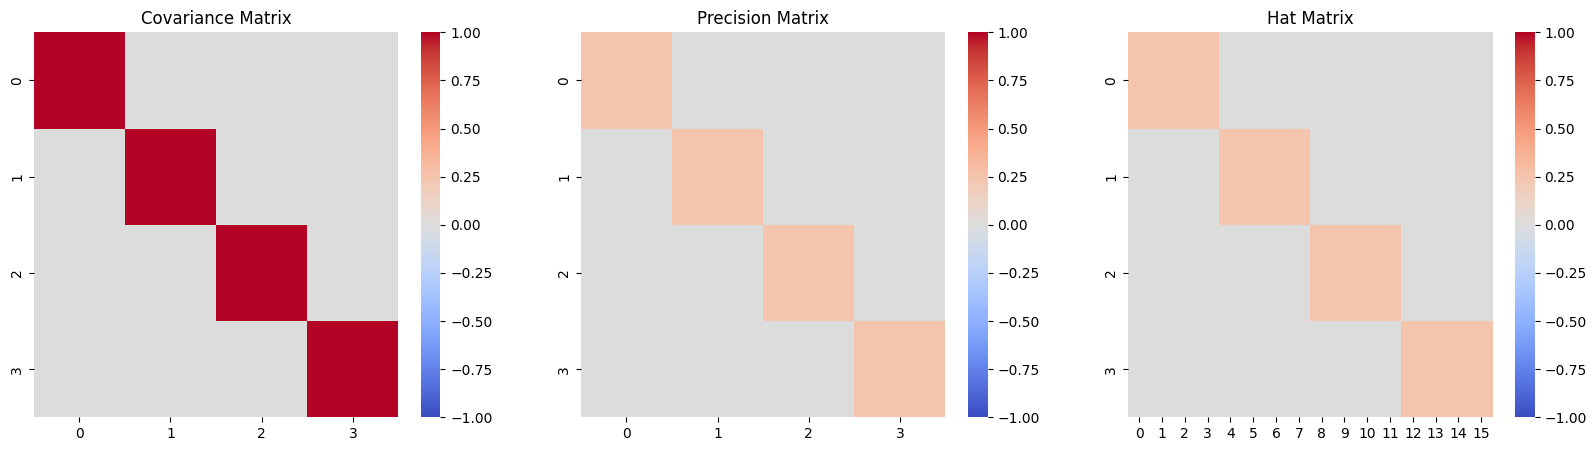

In [23]:
variable_analysis(design_matrix) # variable analysis

In [24]:
# Model the data
true_outcomes = the_spreadsheet['Return']

linear = LinearRegression(fit_intercept=False) # input, output, intercept
linear.fit(design_matrix, true_outcomes)
linear_outcomes = linear.predict(design_matrix)
linear_weights = linear.coef_

ridge = RidgeCV(alphas=[0.001, 0.01, 1.0], fit_intercept=False) # input, output, alphas, intercept, cv
ridge.fit(design_matrix, true_outcomes)
ridge_outcomes = ridge.predict(design_matrix)
ridge_weights = ridge.coef_

In [26]:
true_weights.shape

(6,)

In [27]:
linear_weights.shape

(4,)

In [28]:
ridge_weights.shape

(4,)

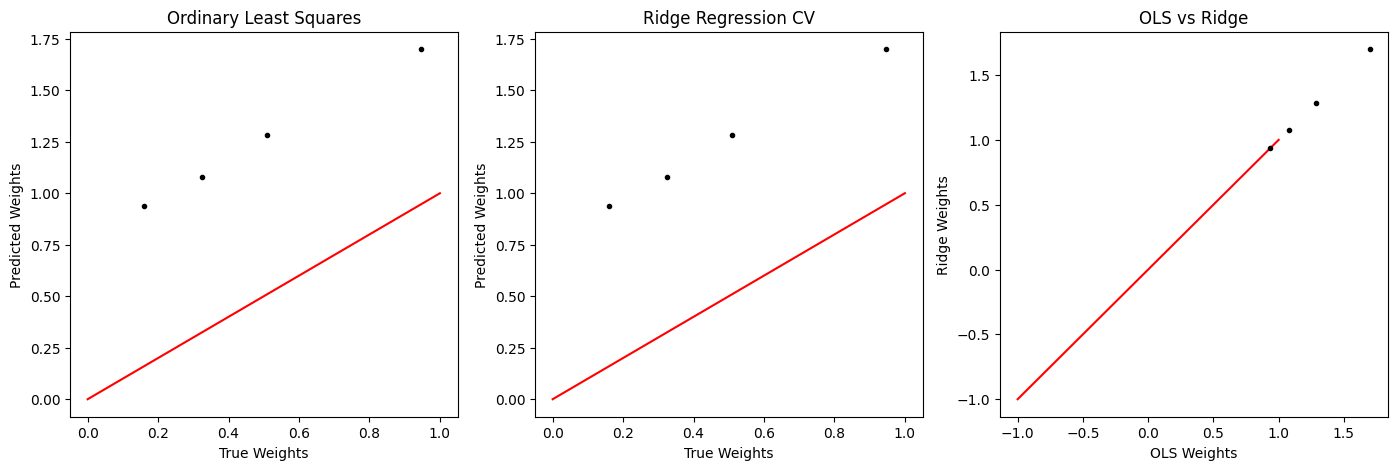

True Weights:
 [0.94582007 0.32539065 0.16012399 0.50878895] 

Linear Weights:
 [1.69922237 1.07879295 0.9357011  1.28436606] 

Ridge Weights:
 [1.69879767 1.07852332 0.93546723 1.28404504]


In [30]:
compare_model_weights_accuracy(true_weights[:4], linear_weights, ridge_weights) # Evaluate regressions ability to predict variable weights

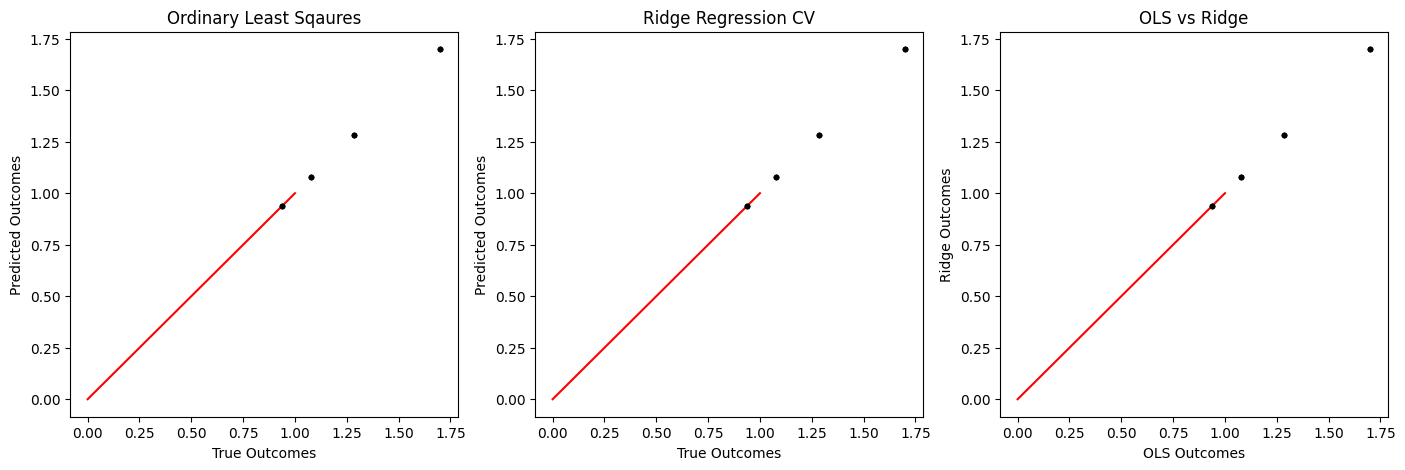

In [31]:
compare_model_outcomes_accuracy(true_outcomes, linear_outcomes, ridge_outcomes) # Evaluate regressions ability to predict outcomes

# plot axis in opposite order
# in real life im not in control of true outcome im only in control of predicitons
# in reality im interested in what I calculated (x-axis) vs what i trianed it with (on y axis)

In [34]:
# evaluate model metrics

# LINEAR
evaluation_metrics(true_weights[:4], linear_weights, true_outcomes, linear_outcomes)

Mean Squared Error: 2.465190328815662e-32
Mean Weight Error: -0.7644897031933663
Model Variance: 0.00012293053664293047
Standard Deviation: 0.011087404414150792


In [35]:
# RIDGE CV
evaluation_metrics(true_weights[:4], ridge_weights, true_outcomes, ridge_outcomes)

Mean Squared Error: 1.0270307308081294e-07
Mean Weight Error: -0.7641774011146216
Model Variance: 0.00012370878847073785
Standard Deviation: 0.011122445255911034




---



---



In [36]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(design_matrix, true_outcomes, test_size=0.2, random_state=42)

# Model

linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
linear_weights = linear.coef_

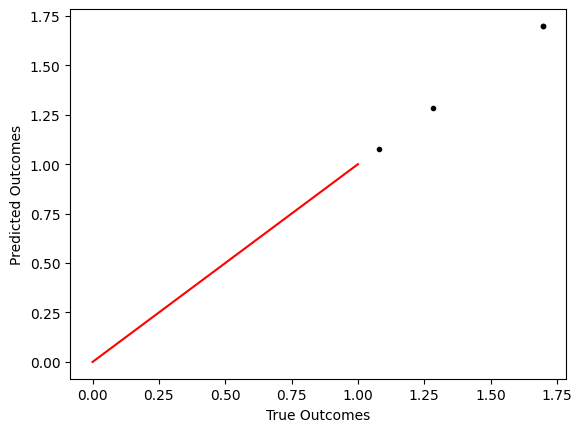

In [37]:
model_outcomes_accuracy(y_test, y_pred)

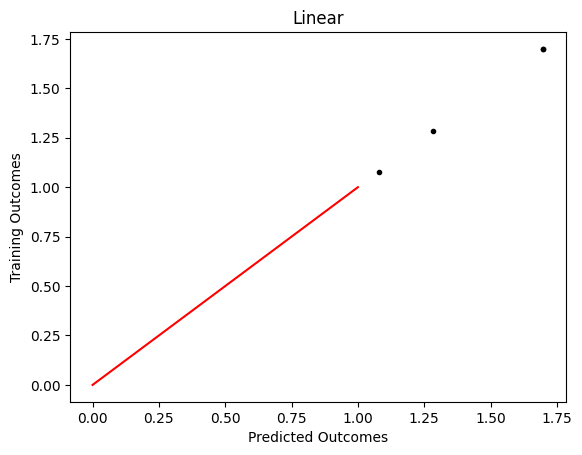

In [38]:
pyplot.title('Linear')
pyplot.xlabel('Predicted Outcomes')
pyplot.ylabel('Training Outcomes')

pyplot.plot([0,1], [0,1], 'r-')
pyplot.plot(y_pred, y_test, 'k.')

In [39]:
mse = mean_squared_error(y_test, y_pred)
mse

1.232595164407831e-31

In [40]:
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_weights = ridge.coef_

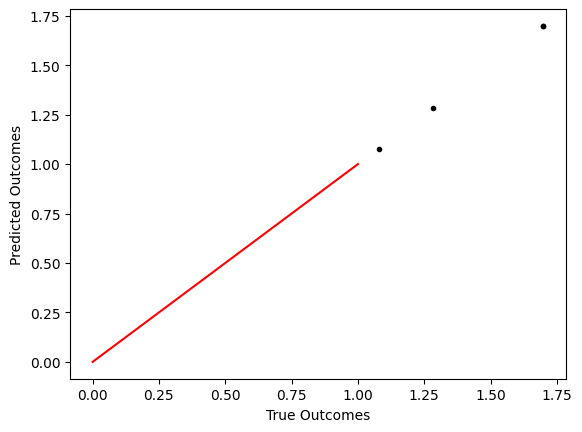

In [41]:
model_outcomes_accuracy(y_test, y_pred)

In [42]:
mse = mean_squared_error(y_test, y_pred)
mse

4.386565911044825e-07

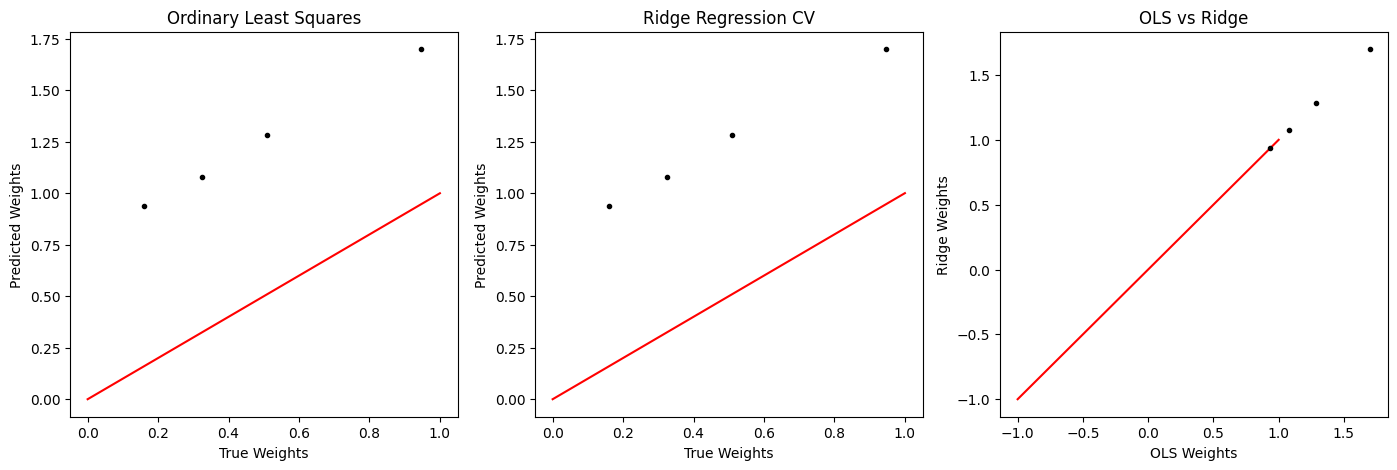

True Weights:
 [0.94582007 0.32539065 0.16012399 0.50878895] 

Linear Weights:
 [1.69922237 1.07879295 0.9357011  1.28436606] 

Ridge Weights:
 [1.69837318 1.07843347 0.93546723 1.28393808]


In [44]:
compare_model_weights_accuracy(true_weights[:4], linear_weights, ridge_weights)